In [1]:

import matplotlib.pyplot as plt

import sim.evaluation
import sim.model_configuration
import sim.petrinet_replay
import sim.simulator
import sim.viz
import util
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 7]

%load_ext autoreload
%aimport sim.petrinet_replay
%aimport sim.viz
%aimport sim.replay_tracking
%aimport sim.simulator
%aimport sim.sim_model
%aimport sim.sim_data
%aimport sim.managers
%aimport sim.parameter_extraction
%aimport sim.petrinet_replay
%aimport sim.parameter_defaults
%aimport sim.model_configuration
%aimport sim.utils
%aimport sim.evaluation
%aimport sim.case
%aimport sim.importing

%autoreload 1

%config InlineBackend.figure_format = 'retina'

ModuleNotFoundError: No module named 'util'

In [ ]:
from pm4py.objects.log.importer.xes import importer
orig_log = importer.apply('easy_test.xes')
print(len(orig_log))

In [ ]:
#log = importer.sample_log(orig_log, 1000)
log = orig_log

In [ ]:
discovery_log = util.general_log_filter(log, lambda ev: ev['lifecycle:transition'] == 'complete')

In [ ]:
from pm4py.visualization.dfg import visualizer as dfg_viz
from pm4py.algo.discovery.dfg import algorithm as dfg_miner
dfg = dfg_miner.apply(discovery_log)
dfg_viz.apply(dfg)

In [ ]:
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

tree = inductive_miner.apply_tree(discovery_log)

In [ ]:
from pm4py.visualization.process_tree import visualizer as tree_visualizer

tree_viz = tree_visualizer.apply(tree)

tree_visualizer.view(tree_viz)

In [ ]:
from pm4py.objects.conversion.process_tree import converter as conv
net, im, fm = conv.apply(tree, variant=conv.Variants.TO_PETRI_NET)

In [ ]:
from pm4py.visualization.petrinet import visualizer as petri_visualizer

net_viz = petri_visualizer.apply(net, im, fm)

petri_visualizer.view(net_viz)

In [ ]:
def trackers_overview(trackers):
    def q_plot(key):
        for a, tr in trackers['activity_trackers'].items():
            tr.queue_model.queueing_history_df[key].plot(label=f'{a}')
        plt.legend()
        plt.title(f'chronological {key}')
        plt.show()
    q_plot('queue_length')
    print('act\tavg wait\t\t\tavg processing')
    for a, tr in trackers['activity_trackers'].items():
        print(f'{a}\t{tr.queue_model.queueing_history_df["wait"].mean()}\t{tr.processing_model.processing_history_df["duration"].mean()}')


In [ ]:
def log_to_sim(input_log, viz_graph=False):
    flog = util.general_log_filter(input_log, lambda ev: ev['lifecycle:transition'] == 'start' or ev['lifecycle:transition'] == 'complete')
    trackers, decision_points = sim.petrinet_replay.replay_log(flog, net, im, fm)
    graph = sim.model_configuration.create_sim_graph(net, im, fm, decision_points)
    config = sim.model_configuration.create_model_configuration(**trackers)
    sm = sim.simulator.create_simulation_model(graph, config, sim.simulator.default_execution_parameters())
    simul = sim.simulator.simulate(sm)
    sim_log = simul.get_log()
    trackers_overview(trackers)
    return sim_log

In [ ]:
sim_log = log_to_sim(log, True)

In [ ]:
sim.evaluation.compare_emd(log, sim_log)

In [ ]:
sim.evaluation.compare_qualitative(log, sim_log)

In [ ]:
sim_log2 = log_to_sim(sim_log)

In [ ]:
sim.evaluation.compare_emd(sim_log, sim_log2)

count                         1000
mean     0 days 22:02:47.468115775
std      0 days 21:41:51.913533157
min         0 days 00:33:40.457459
25%         0 days 04:42:53.980999
50%      0 days 19:04:48.853885500
75%         1 days 01:36:03.248996
max         3 days 20:35:03.634976
dtype: object
count                         1000
mean     2 days 05:42:44.874063645
std      1 days 13:39:14.694337462
min         0 days 00:56:27.259961
25%      0 days 22:54:08.771332750
50%      1 days 23:17:36.361382500
75%      3 days 03:28:56.595857250
max         5 days 20:51:28.767518
dtype: object


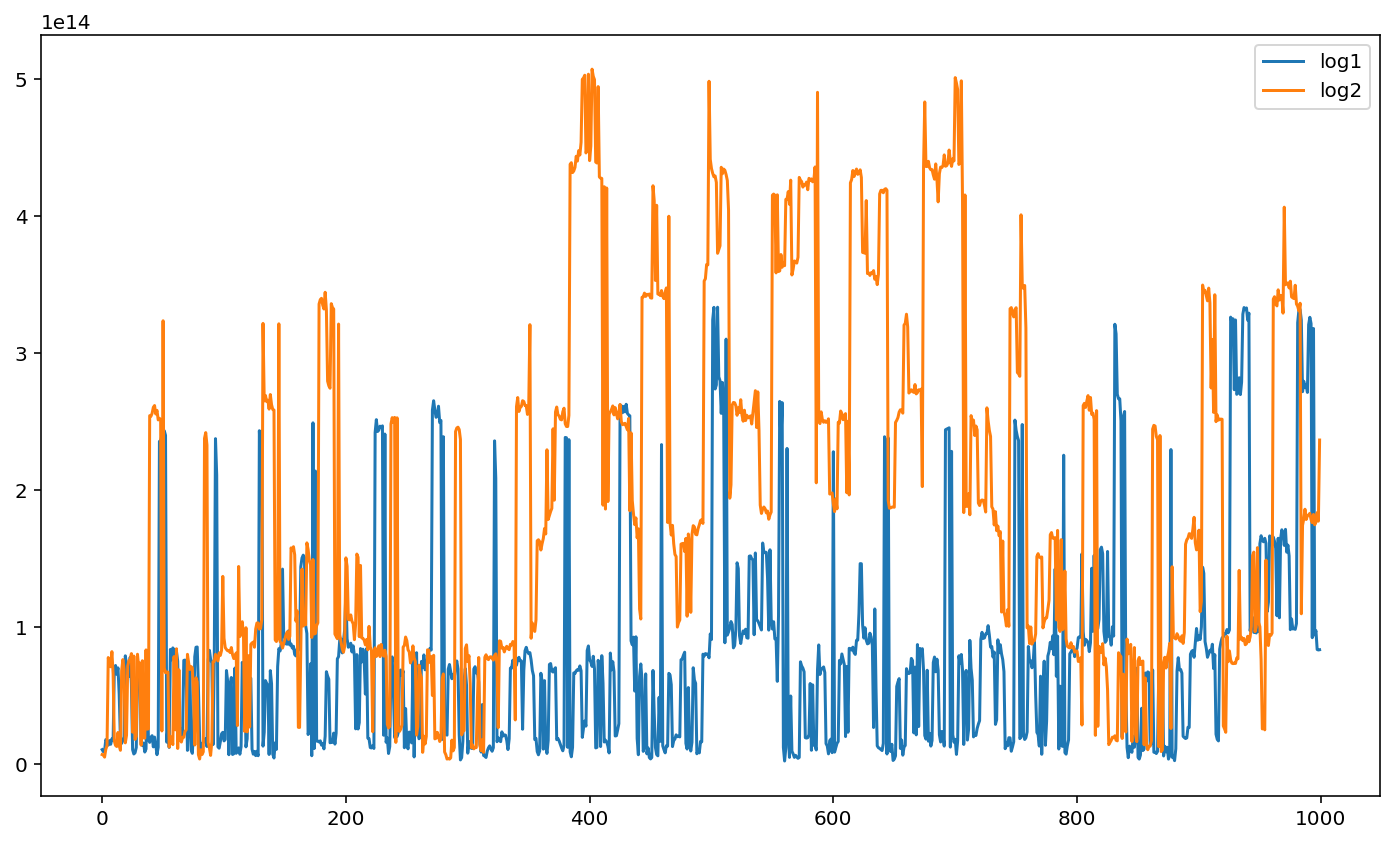

In [17]:
sim.evaluation.compare_qualitative(sim_log, sim_log2)

In [18]:
def pack_lifecycle(log):
    result = log.__copy__()
    for trace in result:
        for event in trace:
            event['classifier'] = f"{event['concept:name']}-{event['lifecycle:transition']}"
    return result

def unpack_lifecycle(log):
    result = log.__copy__()
    for trace in result:
        for event in trace:
            a, l = event['concept:name'].split('-')
            event['concept:name'] = a
            event['lifecycle:transition'] = l
    return result

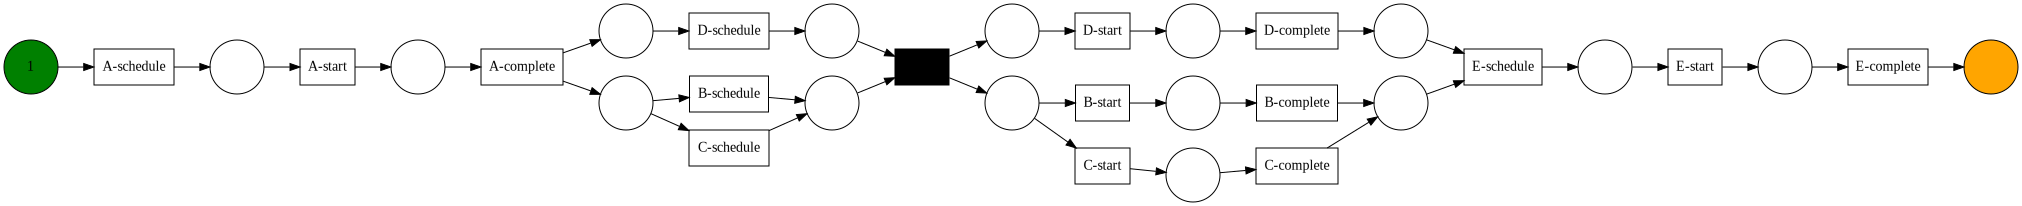

In [19]:
from pm4py.algo.discovery.parameters import Parameters

full_net, full_im, full_fm = inductive_miner.apply(pack_lifecycle(log), parameters={Parameters.ACTIVITY_KEY: 'classifier'})

petri_visualizer.apply(full_net, full_im, full_fm)

In [20]:
from pm4py.simulation.montecarlo.parameters import Parameters

from pm4py.simulation.montecarlo import simulator as monte_simulator

monte_log, monte_info = monte_simulator.apply(log, full_net, full_im, full_fm, parameters={Parameters.PARAM_ENABLE_DIAGNOSTICS: False, Parameters.PARAM_NUM_SIMULATIONS: 1000})

In [21]:
monte_log = unpack_lifecycle(monte_log)

In [22]:
sim.evaluation.compare_emd(log, monte_log)

#lang1	#lang2	variant
0.0	31.0	('A-schedule', 'A-start', 'A-complete', 'D-schedule', 'C-schedule', 'B-start', 'B-complete', 'D-start', 'D-complete', 'E-schedule', 'E-start', 'E-complete')
0.0	10.0	('A-schedule', 'A-start', 'A-complete', 'D-schedule', 'C-schedule', 'D-start', 'B-start', 'D-complete', 'B-complete', 'E-schedule', 'E-start', 'E-complete')
162.0	27.0	('A-schedule', 'A-start', 'A-complete', 'D-schedule', 'C-schedule', 'C-start', 'C-complete', 'D-start', 'D-complete', 'E-schedule', 'E-start', 'E-complete')
8.0	17.0	('A-schedule', 'A-start', 'A-complete', 'B-schedule', 'D-schedule', 'D-start', 'B-start', 'B-complete', 'D-complete', 'E-schedule', 'E-start', 'E-complete')
4.0	20.0	('A-schedule', 'A-start', 'A-complete', 'C-schedule', 'D-schedule', 'D-start', 'D-complete', 'C-start', 'C-complete', 'E-schedule', 'E-start', 'E-complete')
0.0	14.0	('A-schedule', 'A-start', 'A-complete', 'B-schedule', 'D-schedule', 'D-start', 'C-start', 'C-complete', 'D-complete', 'E-schedule', 'E-st

count                         1000
mean        0 days 14:27:11.038000
std      0 days 17:17:53.742253511
min                0 days 00:29:01
25%         0 days 03:29:52.500000
50%         0 days 05:54:07.500000
75%                0 days 20:03:17
max                3 days 02:39:02
dtype: object
count               1000
mean     0 days 00:00:00
std      0 days 00:00:00
min      0 days 00:00:00
25%      0 days 00:00:00
50%      0 days 00:00:00
75%      0 days 00:00:00
max      0 days 00:00:00
dtype: object


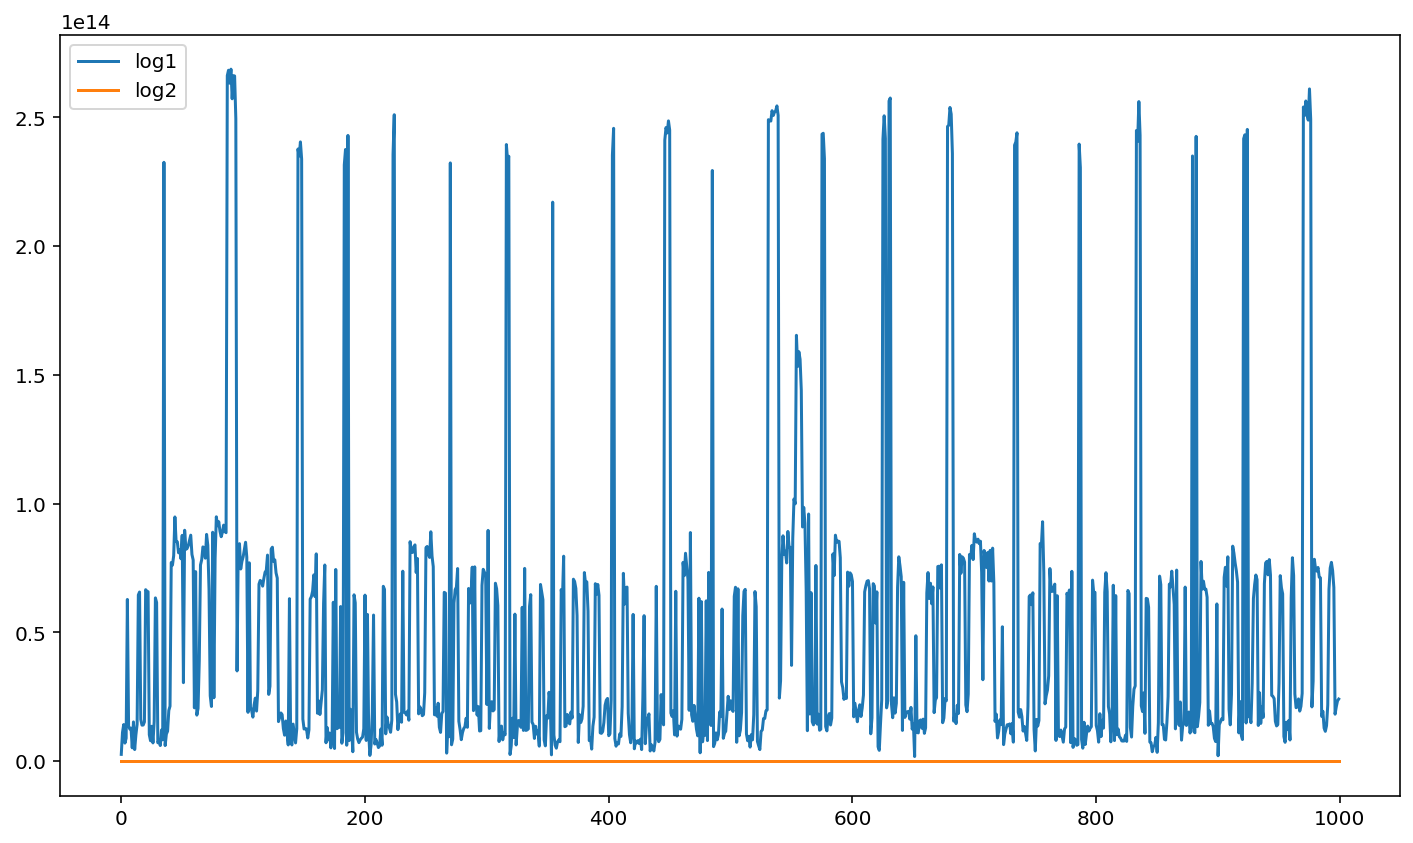

In [23]:
sim.evaluation.compare_qualitative(log, monte_log)